# 👖 Autoencoders on Fashion MNIST

In this notebook, we'll walk through the steps required to train your own autoencoder on the fashion MNIST dataset.

In [1]:
import os

import torch
from torch import nn
import torch.nn.functional as F
import torch.utils.data as data

import torchvision
import torchvision.transforms as transforms


from torchmetrics import Accuracy
import lightning.pytorch as L


## 0. parameters

In [2]:
batch_size = 100

NUM_WORKERS = int(os.cpu_count() / 2)
device = torch.device('mps')

## 1. Prepare the data

In [3]:
transform = transforms.Compose(
    [

        transforms.ToTensor(),
        #transoforms.ToTensor() 외 다른 Normalize()를 적용하지 않은 경우 정규화(Normalize) 한 결과가 0 ~ 1 범위로 변환됩니다.
        transforms.Pad(padding=2)
    ]

)

In [4]:
# Loading TrainSet
trainset = torchvision.datasets.FashionMNIST(root='./data', train=True,
                                        download=True, transform=transform)

# Splitting Trainset to Train / Val
train_set_size = int(len(trainset) * 0.8)
valid_set_size = len(trainset) - train_set_size

seed = torch.Generator().manual_seed(42)
trainset, validset = torch.utils.data.random_split(trainset, [train_set_size, valid_set_size], generator=seed)

In [5]:
# Loading
testset = torchvision.datasets.FashionMNIST(root='./data', train=False,
                                       download=False, transform=transform)


In [6]:
# Making dataloaders

train_dataloader = data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=NUM_WORKERS)

valid_dataloader = data.DataLoader(validset, batch_size=batch_size,
                                          shuffle=False, num_workers=NUM_WORKERS)

test_dataloader =  data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=NUM_WORKERS)

### Accessing a single batch


In [8]:
# Access a single batch from the DataLoader
for batch in train_dataloader:
    images, labels = batch
    break  # We only need one batch for this example

# Access individual samples from the batch
images.shape
#labels.shape

torch.Size([100, 1, 32, 32])

## 2. Build the model

In [7]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=2, padding=1)
        self.fc1 = nn.Linear(128 * 4 * 4, 2)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        return x

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(2, 128 * 4 * 4)
        self.convt1 = nn.ConvTranspose2d(in_channels=128, out_channels=128, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.convt2 = nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.convt3 = nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.conv1 = nn.Conv2d(in_channels=32, out_channels=1, kernel_size=3, stride=1, padding=1)

    def forward(self, x):
        x = self.fc1(x)
        x = x.view(-1, 128, 4, 4)
        x = F.relu(self.convt1(x))
        x = F.relu(self.convt2(x))
        x = F.relu(self.convt3(x))
        x = torch.sigmoid(self.conv1(x))
        return x



In [8]:
from torchsummary import summary

model = Encoder()
summary(model, (1, 32, 32)) 

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 16, 16]             320
            Conv2d-2             [-1, 64, 8, 8]          18,496
            Conv2d-3            [-1, 128, 4, 4]          73,856
            Linear-4                    [-1, 2]           4,098
Total params: 96,770
Trainable params: 96,770
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.11
Params size (MB): 0.37
Estimated Total Size (MB): 0.48
----------------------------------------------------------------


In [9]:
from torchsummary import summary

model = Decoder()
summary(model, (2,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                 [-1, 2048]           6,144
   ConvTranspose2d-2            [-1, 128, 8, 8]         147,584
   ConvTranspose2d-3           [-1, 64, 16, 16]          73,792
   ConvTranspose2d-4           [-1, 32, 32, 32]          18,464
            Conv2d-5            [-1, 1, 32, 32]             289
Total params: 246,273
Trainable params: 246,273
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.46
Params size (MB): 0.94
Estimated Total Size (MB): 1.40
----------------------------------------------------------------


In [10]:
class LitAutoEncoder(L.LightningModule):
    def __init__(self, encoder, decoder, lr=0.001):
        super().__init__()

        self.save_hyperparameters()
        self.hparams.lr = lr
        self.encoder = encoder
        self.decoder = decoder
        self.criterion = nn.BCELoss()

    def forward(self, x):

        z = self.encoder(x)
        x_hat = self.decoder(z)
        return x_hat

    def training_step(self, batch):
        x, _ = batch
     
        z = self.encoder(x)
        x_hat = self.decoder(z)

        loss = self.criterion(x_hat, x)
        self.log("train_loss", loss, on_step=False, on_epoch=True)

        return loss
    
    def validation_step(self, batch):
        x, _ = batch

        z = self.encoder(x)
        x_hat = self.decoder(z)

        loss = self.criterion(x_hat, x)
        self.log("val_loss", loss, on_step=False, on_epoch=True)

        return loss
    
    def test_step(self, batch):
        x, _ = batch
     
        z = self.encoder(x)
        x_hat = self.decoder(z)

        loss = self.criterion(x_hat, x)
        self.log("test_loss", loss, on_step=False,
                 on_epoch=True)

        return loss
    def predict_step(self, batch, batch_idx, dataloader_idx=0):
        return self(batch)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.hparams.lr)
        return optimizer


## 3. Train the model with Early Stopping

In [ ]:
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
model = LitAutoEncoder(Encoder(), Decoder())
#model = LitAutoEncoder.load_from_checkpoint("/path/to/checkpoint.ckpt")

early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=0.00,  verbose=0, mode="min")
trainer = L.Trainer(
    callbacks=[early_stop_callback],
    max_epochs=5,
    default_root_dir="./log",
)



In [ ]:
trainer.fit(model, train_dataloader, valid_dataloader)

## 4. Evaluation

In [13]:
checkpoint = "./log/lightning_logs/version_0/checkpoints/epoch=4-step=2400.ckpt"
model = LitAutoEncoder.load_from_checkpoint(checkpoint)
trainer = L.Trainer()

trainer.test(model, dataloaders=test_dataloader)

/Users/jjookim/miniconda3/envs/ml_project/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'encoder' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['encoder'])`.
/Users/jjookim/miniconda3/envs/ml_project/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'decoder' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['decoder'])`.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: /Users/jjookim/Studies/DeepGenerativeAI/AutoEncoder(Chapter3)/01_autoencoder/lightning_logs
/Users/jjookim/miniconda3/envs/ml_project/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider se

Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    0.25291383266448975    │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.25291383266448975}]

## 5. Reconstruct the images

In [12]:
for batch in test_dataloader:
    example_images, example_labels = batch
    break  


In [17]:
import matplotlib.pyplot as plt

def show_images(images, labels, n=10):
    images = images[:n]
    labels = labels[:n]
    fig, axes = plt.subplots(1, n, figsize=(15, 5))
    
    for i in range(n):
        img = images[i]

        img = transforms.ToPILImage()(img)
        
        axes[i].imshow(img)
        axes[i].set_title(f'Label: {labels[i].item()}')
        axes[i].axis('off')
    
    plt.show()

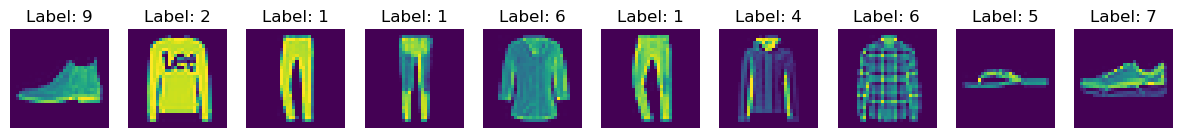

In [16]:
show_images(example_images, example_labels)

In [15]:

checkpoint = "./log/lightning_logs/version_0/checkpoints/epoch=4-step=2400.ckpt"
model = LitAutoEncoder.load_from_checkpoint(checkpoint)
model.eval()
example_images = example_images.to(device)

with torch.no_grad():
    predictions = model(example_images)

/Users/jjookim/miniconda3/envs/ml_project/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'encoder' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['encoder'])`.
/Users/jjookim/miniconda3/envs/ml_project/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'decoder' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['decoder'])`.


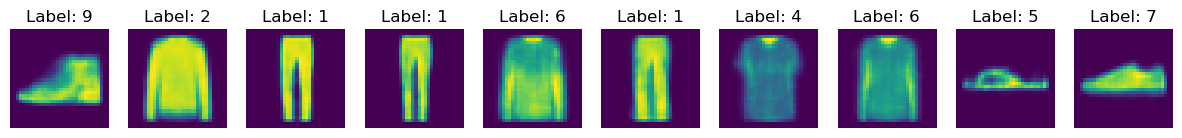

In [18]:
show_images(predictions, example_labels)

## 7. Visualizing the Latent Space

In [19]:
n_to_predict = 5000

In [20]:
test_dataloader =  data.DataLoader(testset, batch_size=n_to_predict,
                                         shuffle=False, num_workers=NUM_WORKERS)

In [21]:
for batch in test_dataloader:
    example_images, example_labels = batch
    break  

In [22]:
example_images.shape

torch.Size([5000, 1, 32, 32])

In [23]:
example_images = example_images.to(device)

In [24]:
checkpoint = "./log/lightning_logs/version_0/checkpoints/epoch=4-step=2400.ckpt"
model = LitAutoEncoder.load_from_checkpoint(checkpoint)
model.eval()
with torch.no_grad():
    embeddings = model.encoder(example_images)

In [25]:
embeddings = embeddings.cpu().detach().numpy()

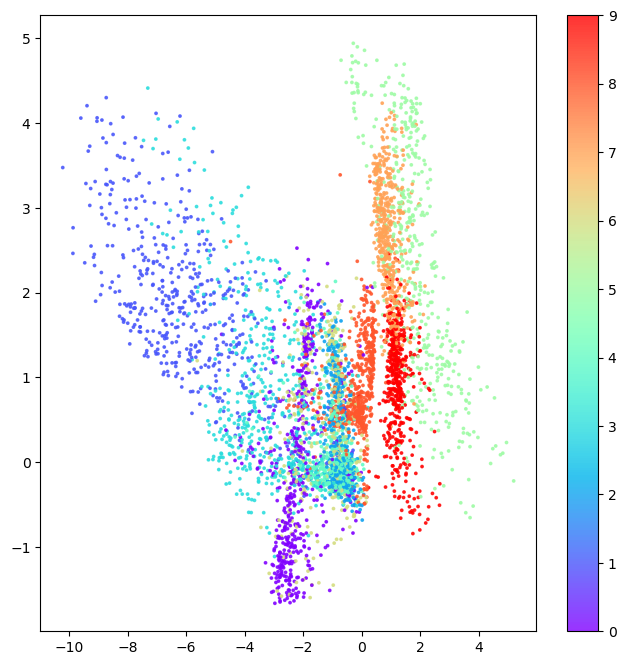

In [26]:
import matplotlib.pyplot as plt
figsize = 8
plt.figure(figsize=(figsize, figsize))
plt.scatter(
    embeddings[:, 0],
    embeddings[:, 1],
    cmap="rainbow",
    c=example_labels,
    alpha=0.8,
    s=3,
)
plt.colorbar()
plt.show()

## 8. Generate using the decoder

In [27]:
embeddings

array([[ 1.5275382 ,  1.8672286 ],
       [-0.55837685, -0.2621369 ],
       [-7.256788  ,  1.4138826 ],
       ...,
       [ 1.1178733 , -0.34168962],
       [-2.9943619 ,  0.6118964 ],
       [ 0.5396179 ,  3.4321735 ]], dtype=float32)

In [28]:
import numpy as np
# Get the range of the existing embeddings
mins, maxs = np.min(embeddings, axis=0), np.max(embeddings, axis=0)

# Sample some points in the latent space
grid_width, grid_height = (6, 3)
sample = np.random.uniform(
    mins, maxs, size=(grid_width * grid_height, 2)
)

In [29]:
sample = sample.astype(np.float32)
sample = torch.from_numpy(sample)

device = torch.device("mps")
sample = sample.to(device)


In [30]:
checkpoint = "./log/lightning_logs/version_0/checkpoints/epoch=4-step=2400.ckpt"
model = LitAutoEncoder.load_from_checkpoint(checkpoint)
model.eval()
with torch.no_grad():
    reconstructions = model.decoder(sample)

/Users/jjookim/miniconda3/envs/ml_project/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'encoder' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['encoder'])`.
/Users/jjookim/miniconda3/envs/ml_project/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'decoder' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['decoder'])`.


In [33]:
reconstructions = reconstructions.cpu().detach().numpy()

In [43]:
reconstructions.shape

(18, 1, 32, 32)

In [39]:
sample = sample.cpu().detach().numpy()

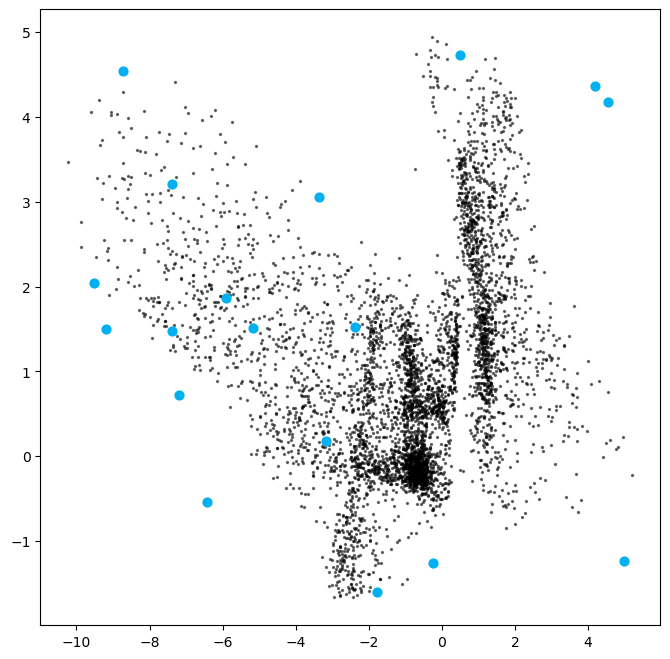

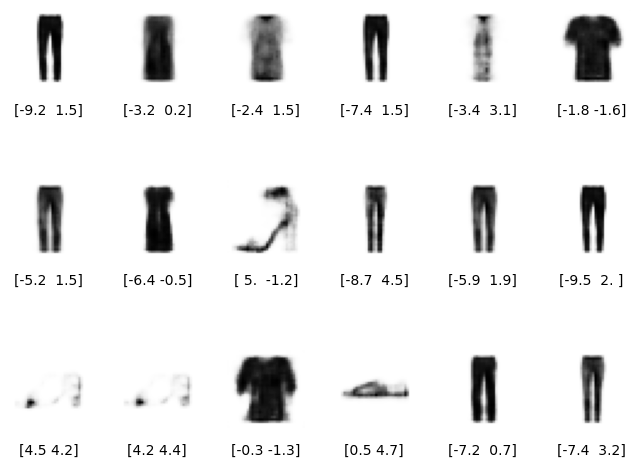

In [44]:
# Draw a plot of...
figsize = 8
plt.figure(figsize=(figsize, figsize))

# ... the original embeddings ...
plt.scatter(embeddings[:, 0], embeddings[:, 1], c="black", alpha=0.5, s=2)

# ... and the newly generated points in the latent space
plt.scatter(sample[:, 0], sample[:, 1], c="#00B0F0", alpha=1, s=40)
plt.show()

# Add underneath a grid of the decoded images
fig = plt.figure(figsize=(figsize, grid_height * 2))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i in range(grid_width * grid_height):
    ax = fig.add_subplot(grid_height, grid_width, i + 1)
    ax.axis("off")
    ax.text(
        0.5,
        -0.35,
        str(np.round(sample[i, :], 1)),
        fontsize=10,
        ha="center",
        transform=ax.transAxes,
    )
    ax.imshow(reconstructions[i][0], cmap="Greys")